In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95%}</style>"))

#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
import sklearn, sklearn.svm

### Visualize a classifier like (logistic regression, random forest, SVM) ##########################
from matplotlib.colors import ListedColormap
def plot_binary_classifier(clf, X, y, alpha=0.2, h=0.02):   # should be 2D feature space 

    # initialize custom marker and color-map :  
    #markers = ('o', '^', 's', 'x', 'v', 'D', '*')
    markers = ('o', 'o', 'o', 'o', 'o', 'o', 'o')
    colors = ('red', 'blue', 'green', 'cyan', 'magenta', 'yellow', 'gray')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    #fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
    
    # create a mesh to plot in
    buffer=0.5
    x_min, x_max = X[:, 0].min() - buffer, X[:, 0].max() + buffer
    y_min, y_max = X[:, 1].min() - buffer, X[:, 1].max() + buffer
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Plot the decision boundary.
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape) # Put the result into a color plot
    plt.contourf(xx, yy, Z, alpha=alpha, cmap=cmap) #cmap = 'afmhot'

    # Plot sample points
    for idx, cls in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cls, 0], y=X[y == cls, 1], c=cmap(idx), s=30,marker=markers[idx], label=cls)#,edgecolors='black')
        
    plt.legend(loc='upper right', frameon=True, framealpha=0.3, borderaxespad=0.9)
    # additionally, support vectors have a white hole in a marker  
    if isinstance(clf, sklearn.svm.classes.SVC):

        # get the separating hyperplane
        x_coordinate = np.linspace(x_min,x_max,3)
        w = clf.coef_[0]
        a = -w[0] / w[1]
        yy_hyper = a * x_coordinate - (clf.intercept_[0]) / w[1]
        plt.plot(x_coordinate, yy_hyper, 'k-')
        
        # plot the parallels to the separating hyperplane that pass through the support vectors
        support_vectors_1 = clf.support_vectors_[y[clf.support_]==1]
        b = support_vectors_1[clf.decision_function(support_vectors_1).argmax()]
        yy_down = a * x_coordinate + (b[1] - a * b[0])
        plt.plot(x_coordinate, yy_down, 'b--')
        
        support_vectors_0 = clf.support_vectors_[y[clf.support_]==0]
        b = support_vectors_0[clf.decision_function(support_vectors_0).argmin()]
        yy_up = a * x_coordinate + (b[1] - a * b[0])
        plt.plot(x_coordinate, yy_up, 'b--')
        
        ## Plotting Support Vectors
        sv = clf.support_vectors_
        #plt.scatter(sv[:,0], sv[:,1], c='w', marker='.', s=25)
        plt.scatter(sv[:, 0], sv[:, 1], s=120,facecolors='none',edgecolors='black')
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)                
        print('\033[1m Number of Support Vectors(Class, SV):\033[0m', list(zip(clf.classes_, clf.n_support_)) )
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


## Define a function to plot classifier
def plot_classifier(clf, X, y, alpha=0.2, h=0.02, target_names=None, hyperplane=False):
    colors = 'brkyg' ## colors for different classes
    ## h=0.02 step size in the mesh
    ## create a mesh to plot in
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min,x_max,h), np.arange(y_min,y_max,h))

    ## plot decision boundary
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    #Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=alpha)
    
    ## Plot the training points
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y==i)
        plt.scatter(X[idx,0], X[idx,1], c=color, cmap=plt.cm.Paired, s=50, label=i) #edgecolor='k'
    ## plot support vectors
    plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], c='w', marker='.', s=30)
    #plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], s=150, linewidth=1, facecolors='none', edgecolor='k')
    print('\033[1m Number of Support Vectors(Class, SV):\033[0m', list(zip(clf.classes_, clf.n_support_)) )
    
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    if hyperplane:
        # Plot the three one-against-all clfs
        coef = clf.coef_
        intercept = clf.intercept_

        def plot_hyperplane(c, color):
            def line(x0):
                return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
            plt.plot([xmin, xmax], [line(xmin), line(xmax)], ls="--", color=color)

        if len(clf.classes_)==2:
            plot_hyperplane(0, 'k')
        elif len(clf.classes_)>2:
            for i, color in zip(clf.classes_, colors):
                plot_hyperplane(i, color)
    
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.legend()

    
###################################################################################################################################
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score


def print_score(clf, X_train, X_test, y_train, y_test, train=False, cv=False):
    '''
    print the accuracy score, classification report and confusion matrix of classifier
    '''
    start = "\033[1;4m"
    end = "\033[0;0m"

    if train:
        '''
        training performance
        '''
        #print(start+'Classifier name'+ end +': ' + str(type(clf)))
        print(start+'Classifier'+ end +': ' + str(clf)+'\n')
        
        print(start+"Train Result:"+end+"\n")
        print("\033[4mConfusion Matrix\033[0;0m:\n{}\n".format(confusion_matrix_df(clf, X_train, y_train)))
        print("\033[4mAccuracy Score\033[0;0m: {0:.4f}".format(accuracy_score(y_train, clf.predict(X_train))))
        print("\n\033[4mClassification Report\033[0;0m:\n{}".format(classification_report(y_train, clf.predict(X_train), digits=4)))
        
        if cv:
            print('Running '+str(cv)+'-fold cross validation:')
            res = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
            print("Average Accuracy: \t{0:.4f}".format(np.mean(res)))
            print("Accuracy SD: \t\t{0:.4f}".format(np.std(res)))
        print('-----'*20)
    else:
        '''
        test performance
        '''
        print(start+"Test Result:"+end+"\n")
        print("\033[4mConfusion Matrix\033[0;0m:\n{}\n".format(confusion_matrix_df(clf, X_test, y_test)))
        print("\033[4mAccuracy Score\033[0;0m: {0:.4f}".format(accuracy_score(y_test, clf.predict(X_test))))
        print("\n\033[4mClassification Report\033[0;0m:\n{}\n".format(classification_report(y_test, clf.predict(X_test), digits=4)))
        
        if cv:
            print('Running '+str(cv)+'-fold cross validation:')
            res = cross_val_score(clf, X_test, y_test, cv=cv, scoring='accuracy')
            print("Average Accuracy: \t{0:.4f}".format(np.mean(res)))
            print("Accuracy SD: \t\t{0:.4f}".format(np.std(res)))
        print('-----'*20)
        
def confusion_matrix_df(clf, X, y):
    cm = confusion_matrix(y, clf.predict(X))
    cm_df = pd.DataFrame(cm, index=clf.classes_, columns=clf.classes_)
    cm_df.index.name = 'True'
    cm_df.columns.name = 'Pred >>'
    return cm_df

# References:

1. [Support Vector Machine in Javascript Demo by Karpathy](http://cs.stanford.edu/people/karpathy/svmjs/demo/)

2. [SVM](http://www.svms.org/tutorials/)

3. [Statsoft](http://www.statsoft.com/Textbook/Support-Vector-Machines)

4. [Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine)

5. [Scikit-Learn](http://scikit-learn.org/stable/modules/svm.html)

# Support Vector Machine (SVM)

## Definition
Support Vector Machine([SVM](https://en.wikipedia.org/wiki/Support_vector_machine)) are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. 

## Bit of History

Invented in [1963](https://en.wikipedia.org/wiki/Support_vector_machine#History) by [Vladimir N. Vapnik](https://en.wikipedia.org/wiki/Vladimir_Vapnik) and Alexey Ya. Chervonenkis while working at AT&T Bell Labs. Vladimir N. Vapnik joined Facebook AI Research in Nov 2014.

In 1992, Bernhard E. Boser, Isabelle M. Guyon and Vladimir N. Vapnik suggested a way to create nonlinear classifiers by applying the kernel trick to maximum-margin hyperplanes.

The current standard incarnation (soft margin) was proposed by Corinna Cortes and Vapnik in 1993 and published in 1995.

## 1. Support Vector Machines (SVM) Introductory Overview

Support Vector Machines are based on the concept of decision planes that define decision boundaries. A decision plane is one that separates between a set of objects having different class memberships.

* SVM is used for classification, regression and outliers detection.
* Use a small subset of observations(also known as support vector) to draw a hypeplane
* Uses a separating hyperplane to classify different classes
* Uses a weighted mean of distance from hyperplane for regression
* It has a unique property that it only depends on support vectors hence is immune to outliers

### Illustration
Let's creatse two linearly separable class. As we can see below that we have two classes here - purple and red. In classification, we are interested in the best way to separate these two classes.

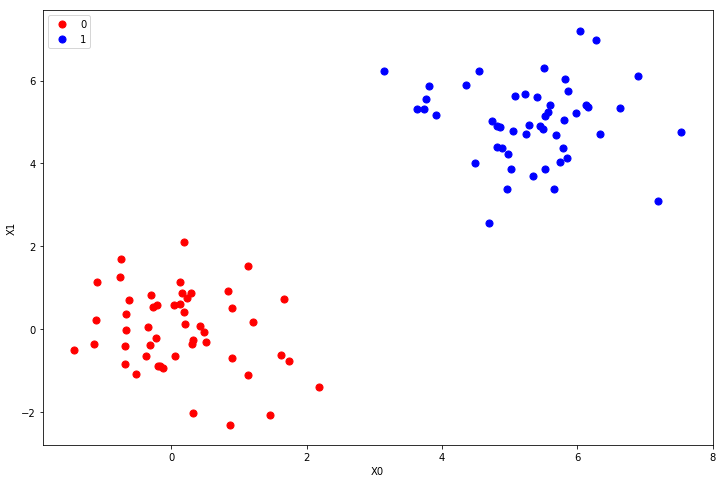

In [3]:
np.random.seed(1)
n_samples = 100
X=np.random.randn(n_samples,2)
y=np.repeat([0,1], n_samples/2)
X[y == 1] = X[y == 1] + 5

fig, ax = plt.subplots()

ax.set_xlabel('X0')
ax.set_ylabel('X1')
# ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
ax.scatter(X[y==0][:,0], X[y==0][:,1], s=50, c='r', marker='o', label='0') 
ax.scatter(X[y==1][:,0], X[y==1][:,1], s=50, c='b', marker='o', label='1') 
ax.legend(loc=2)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

We can separate them with a line such as the example below. You can consider this as an example of how logistic regression would segregate the two classes.

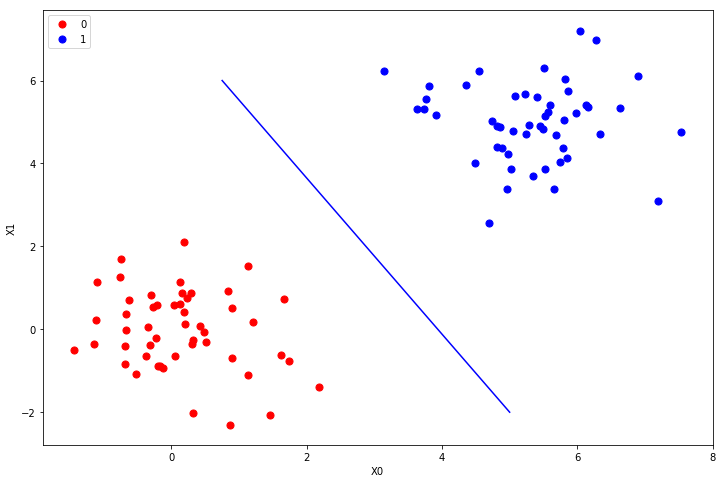

In [4]:
#ax.plot((-1.89813448,7.98234638),(10.08505488, -6.33662303), c='black') ## hyperplane for 5
ax.plot((5,0.75),(-2,6), c='b')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
fig

However, there are infinite lines (in 2-dimensional space) or **hyperplanes** (in 3-dimensional space) that can be used to separate the two classes as the example below illustrates. 

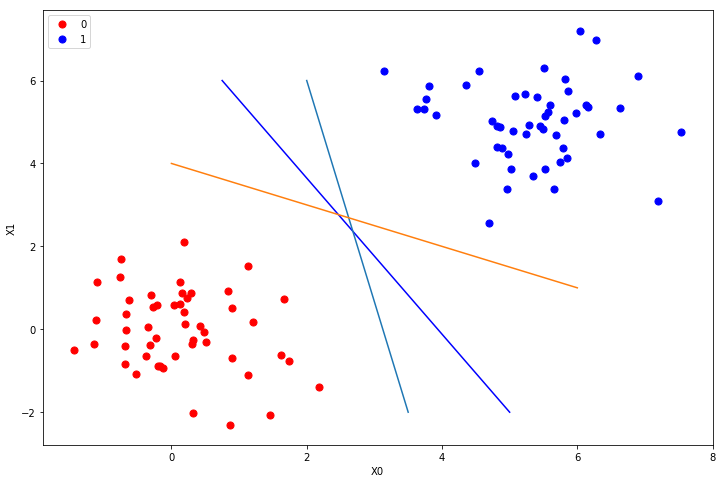

In [5]:
ax.plot((2,3.5),(6,-2))
ax.plot((0,6),(4,1))
fig

In [6]:
## removing the lines from figure
for i in reversed(range(len(ax.lines))):
    del ax.lines[i]

from sklearn.svm import SVC
clf = SVC(kernel='linear')
clf.fit(X, y)
print('Intercept:\t{}'.format(clf.intercept_))
print('Coeff: \t\t{}'.format(clf.coef_))

Intercept:	[-2.02072655]
Coeff: 		[[ 0.4846133   0.29157876]]


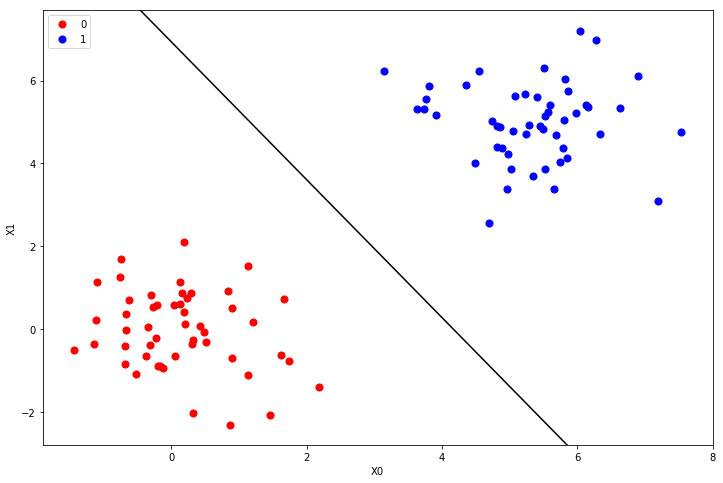

In [7]:
# get the separating hyperplane
xx = np.linspace(xlim[0],xlim[1],10)
w = clf.coef_[0]
a = -w[0] / w[1]
yy_hyper = a * xx - (clf.intercept_[0]) / w[1]

# plot the hyperplane having the maximum margin
ax.plot(xx, yy_hyper, 'k-')
fig

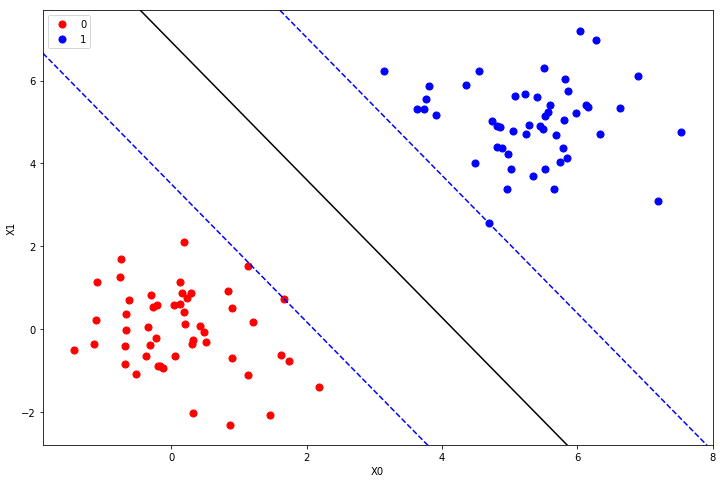

In [8]:
# plot the parallels to the separating hyperplane that pass through the support vectors
b = clf.support_vectors_[0]
yy_down = a * xx + (b[1] - a * b[0])
b = clf.support_vectors_[-1]
yy_up = a * xx + (b[1] - a * b[0])

ax.plot(xx, yy_down, 'b--')
ax.plot(xx, yy_up, 'b--')

# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
fig

The points that are closest to the hyperplane are called **support vectors**, circled in black.

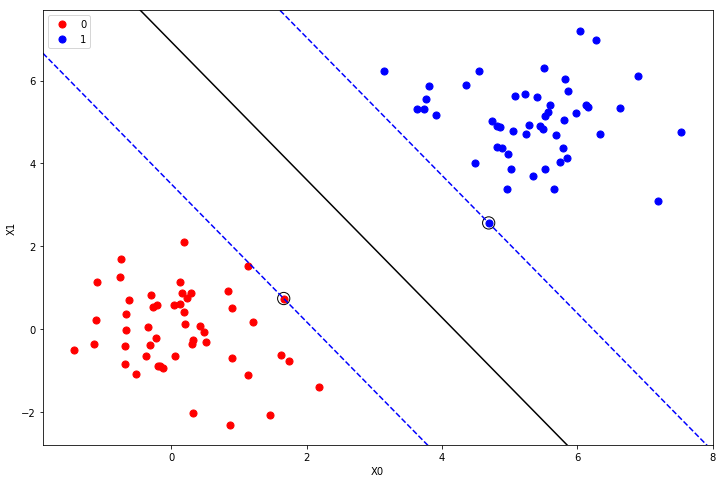

In [9]:
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=150, facecolors='none',edgecolors='black')
fig

##  Support Vector Classifier

SVC tries to classify a given set of observations by locating a **line** that can separate the two classes with maximum margin. This separating line is also called **hyperplane**. The samples that passes through the margin lines or on the wrong side of the margin are called **support vectors**


The term **hyperplane** essentially means it is a subspace of one dimension less than its ambient space. If a space is 3-dimensional then its hyperplanes are the 2-dimensional planes, while if the space is 2-dimensional, its hyperplanes are the 1-dimensional lines. ~ [Wikipedia](https://en.wikipedia.org/wiki/Hyperplane)

Mathematically **Support vector Classifier** is defined as the optimization problem given below:

<img src="img/SVC2.png" height=50% width=75% align="left">

**Left Panel:** Shows the separable case.  **Right Panel:** Shows the nonseparable(overlap) case.

* The decision boundary is the solid line, while the broken lines bound the shaded maximal margin of width $2M=\frac{2}{|| \beta ||}$ where $||\beta||$ is a unit vector such that $\sum_{j=1}^p \beta_j^2=1 $.

* The points labeled as $\xi^*_j$ where $j\epsilon\{1,2,3,4,5\}$, are on the wrong side of their margin by an amount $\xi^*_j=M\xi_j$
* Points on the correct side have $\xi_j^*=0$. The margin is maximized subject to a total budget $\sum_{i=1}^n{\xi_i} \leqslant const.$ for the given sample of size $n$. 

* For the above case $\sum_{j=1}^5{\xi_j}$ is the total distance of points on the wrong side of their margin.


#### The mathematical definition of a hyperplane in 2-dimensional space is given

$\beta_{0} + \beta_{1}x_{1}+\beta_{2}x_{2}=0$, where $\beta_{0}$= Intercept and $\beta_{1}$, $\beta_{2}$ are the coefficients.

The generalized *p-dimensional* equation for a hyperplane can be given as:

$\beta_{0} + \beta_{1}x_{1}+\beta_{2}x_{2}+ ... +\beta_{p}x_{p}=0$ or $\beta_0 + \beta x^T=0 $

#### Classification Logic Using the Hyperplane
For a given point $x^* = (x_{1},x_{2})$ if

* $\beta_{0} + \beta_{1}x_{1}+\beta_{2}x_{2}=0$ $\implies$ the point $x^*$ lies on the hyperplane
* $\beta_{0} + \beta_{1}x_{1}+\beta_{2}x_{2}>0$ $\implies$ y =  1 ($x^*$ lies on the upper side of the hyperplane)
* $\beta_{0} + \beta_{1}x_{1}+\beta_{2}x_{2}<0$ $\implies$ y = -1 ($x^*$ lies on the lower side of the hyperplane)

### Penalty or Cost parameter $C$
* **Hard Margin (Higher Value of C)** - Margin levels are very strict and there will be less violation resulting into less number of support vectors
* **Soft Margin (Lower Value of C)** - Margin levels are relatively relaxed and allows violations resulting into more number of support vectors

 Number of Support Vectors(Class, SV): [(0, 8), (1, 8)]


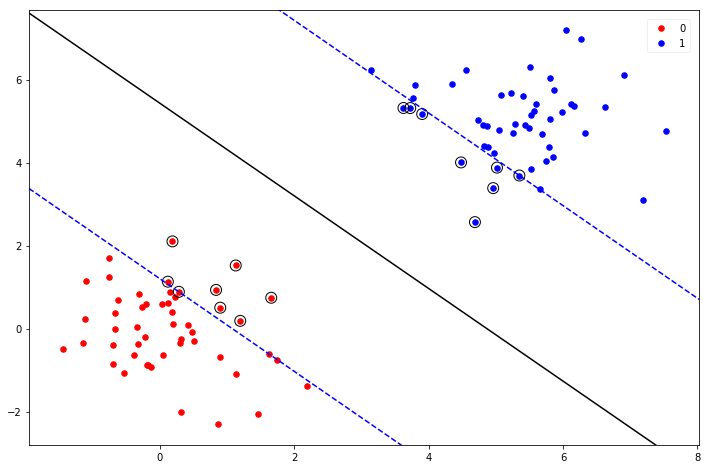

In [10]:
## Examples with lower value of C (Soft margin). See how the number of support vectors are changing with C
clf = SVC(C=0.01, kernel='linear')
clf.fit(X, y)
plot_binary_classifier(clf, X, y, alpha=0)

***

## SVMs with More than Two Classes (K>2)
#### Methods to extend SVM to the K-class
* **One-verses-One** - A one-versus-one or all-pairs approach constructs ${K \choose 2}$ SVMs, each of which compares a pair of classes. Final classification is done on maximum voting. 
* **One-verses-all** - We fit K SVMs, each time comparing one of the K classes to the remaining K-1 classes. A test observation belongs to the class for which the distance from the hyperplane is largest.

The above options can be setup usig the parameter **decision_function_shape = ('ovo','ovr')** from sklearn.svm.SVC class

## Application to Iris dataset

In [11]:
## Iris Dataset
from sklearn import datasets
iris = sns.load_dataset('iris')

X_iris = iris.iloc[:,[0,1]].values
y_iris = iris.species.map({'setosa':0,'versicolor':1,'virginica':2})

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


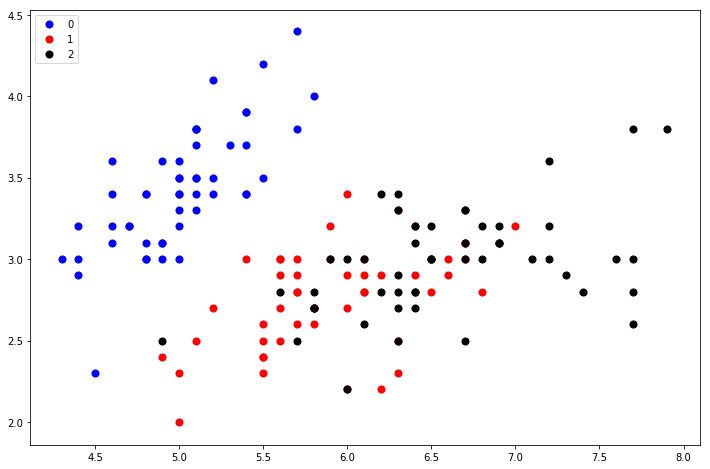

In [14]:
#sns.FacetGrid(iris, hue="species", size=8).map(plt.scatter, "sepal_length", "sepal_width", s=50).add_legend()
plt.scatter(X_iris[y_iris==0][:,0], X_iris[y_iris==0][:,1], s=50, c='b', marker='o', label='0') 
plt.scatter(X_iris[y_iris==1][:,0], X_iris[y_iris==1][:,1], s=50, c='r', marker='o', label='1')
plt.scatter(X_iris[y_iris==2][:,0], X_iris[y_iris==2][:,1], s=50, c='k', marker='o', label='2')
plt.legend(loc=2)

 Number of Support Vectors(Class, SV): [(0, 8), (1, 39), (2, 34)]


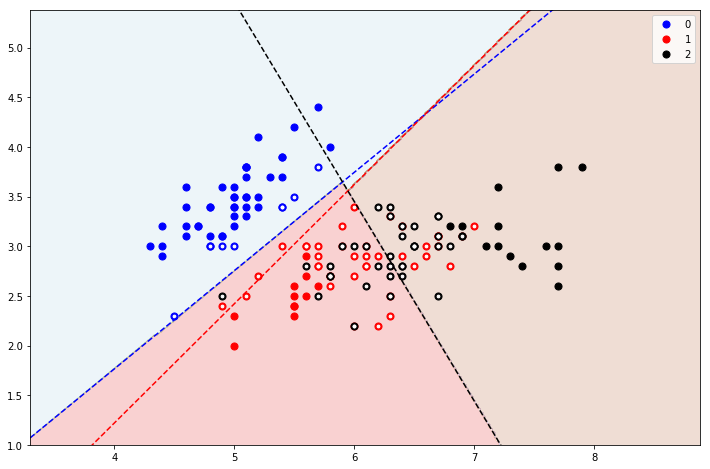

In [15]:
from sklearn.svm import SVC
clf1 = SVC(C=1, kernel='linear', decision_function_shape='ovo') ## default decision_function_shape=None and behaves like 'ovo'
clf1.fit(X_iris,y_iris)
plot_classifier(clf1, X_iris, y_iris, hyperplane=True)
## Not a good choice as there are lots of misclassification. It is a non-linear problem

 Number of Support Vectors(Class, SV): [(0, 8), (1, 39), (2, 34)]


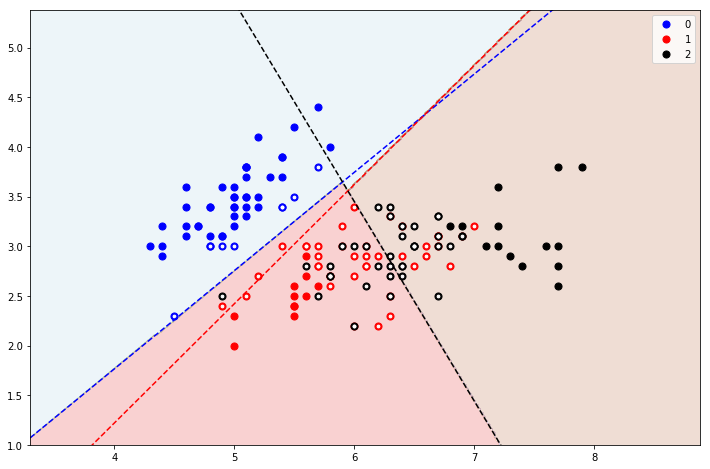

In [16]:
clf2 = SVC(C=1, kernel='linear', decision_function_shape='ovr')
clf2.fit(X_iris ,y_iris)
plot_classifier(clf2, X_iris, y_iris, hyperplane=True)

***

# Non-Linear Support Vector Classifier

## Classification with Non-linear Decision Boundaries

* SVM use kernels to enlarge feature-space in order to accommodate a non-linear boundary between the classes
* Kernal function $K$ gives us a computational advantage, one only need to compute $K(x_i, x_{i'})$ for all ${K \choose 2}$ distinct pairs $i$, $i'$.

### Polynomial Kernel ##### 
## $K(x_i, x_{i'}) = (1+\sum_{j=1}^p (x_{ij}, x_{i'j}))^d$ 
This is kown as polynomial kernel function of degree d with p parameters and $x_i$ and $x_{i'}$ are any two observations from sample n

* As we increase the degree $d$ the flexibility of the model increases
* With the increase of $d$ the bias decrease and variance increase
* We need to tune this parameter to find the optimal level of low bias and low variance

 Number of Support Vectors(Class, SV): [(0, 2), (1, 34), (2, 34)]


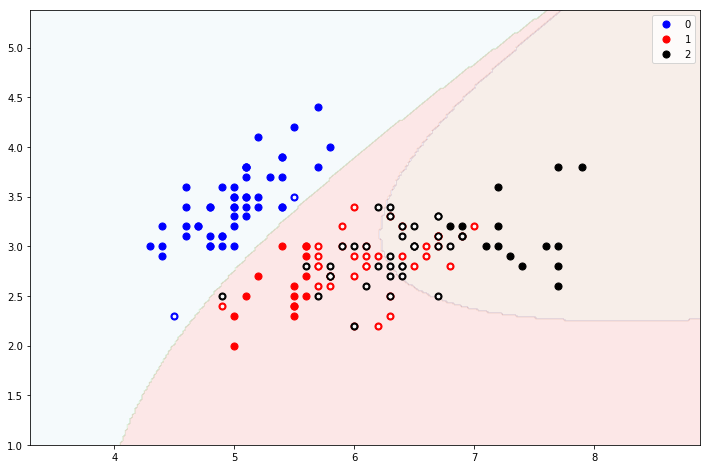

In [17]:
poly_clf = SVC(kernel='poly', C=1, degree=3)
poly_clf.fit(X_iris ,y_iris)
plot_classifier(poly_clf, X_iris, y_iris, alpha=0.1)

### Radial Kernel 
## $K(x_i, x_{i'}) = \exp{(-\gamma\sum_{j=1}^p (x_{ij} - x_{i'j})^2)}$
where $\gamma$ (gamma) is a positive constant
* Greater the value of $\gamma$ the more flexible is the model
* With the increase of $\gamma$, bias decreases but variance increases due to complexity

 Number of Support Vectors(Class, SV): [(0, 11), (1, 41), (2, 35)]


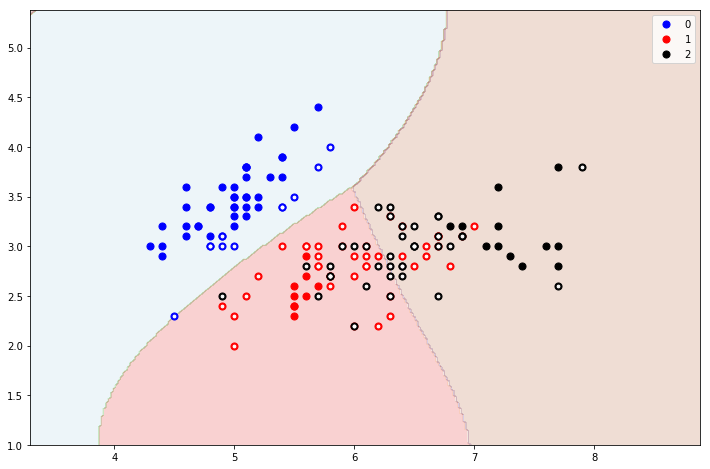

In [18]:
rbf_clf = SVC(kernel='rbf', C=1)
rbf_clf.fit(X_iris ,y_iris)
plot_classifier(rbf_clf, X_iris, y_iris)

#### Reason why only 9 support vectors are visible for class=0

In [19]:
support_df = pd.DataFrame(rbf_clf.support_vectors_,columns=['X_iris','y_iris'])
support_df['Species'] = y_iris[rbf_clf.support_].reset_index(drop=True)
support_df['Species'].value_counts().sort_index()

0    11
1    41
2    35
Name: Species, dtype: int64

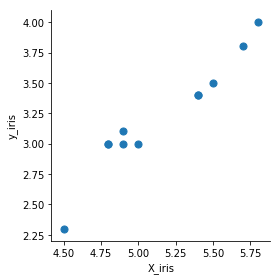

In [20]:
sns.FacetGrid(support_df[support_df['Species']==0], hue='Species', size=4).map(plt.scatter, 'X_iris', 'y_iris', s=50)

In [21]:
# there were two duplicates out of 11 support vector points
support_df[support_df['Species']==0].duplicated()

0     False
1     False
2     False
3     False
4     False
5     False
6      True
7     False
8     False
9     False
10     True
dtype: bool

---

# ROC Curve, Gini, KS for a binary classifier

### Comparison between predict_proba and decision_function results 

* decision_function - Gives the distance from the hyperplane

* predict_prob - Probability that an observation belongs to 0 or 1

 Number of Support Vectors(Class, SV): [(0, 34), (1, 34)]


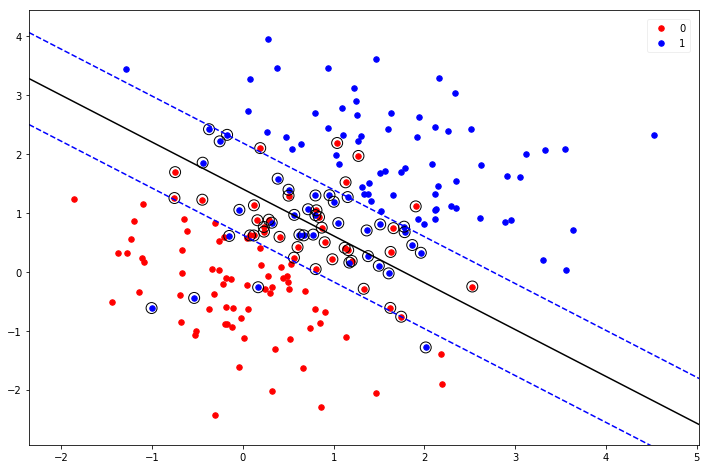

In [28]:
from sklearn.datasets import make_moons

np.random.seed(1)
n_samples = 200
X=np.random.randn(n_samples,2)
y=np.repeat([0,1], n_samples/2)
X[y == 1] = X[y == 1] + 1.5

clf = SVC(C=100, kernel='linear', probability=True)
clf.fit(X, y)
plot_binary_classifier(clf, X, y, alpha=0)

### Confusion Matrix and Classification Report

In [29]:
print_score(clf, X, X, y, y, train=True, cv=10)

Classifier: SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Train Result:

Confusion Matrix:
Pred >>   0   1
True           
0        88  12
1        14  86

Accuracy Score: 0.8700

Classification Report:
             precision    recall  f1-score   support

          0     0.8627    0.8800    0.8713       100
          1     0.8776    0.8600    0.8687       100

avg / total     0.8701    0.8700    0.8700       200

Running 10-fold cross validation:
Average Accuracy: 	0.8700
Accuracy SD: 		0.0557
----------------------------------------------------------------------------------------------------


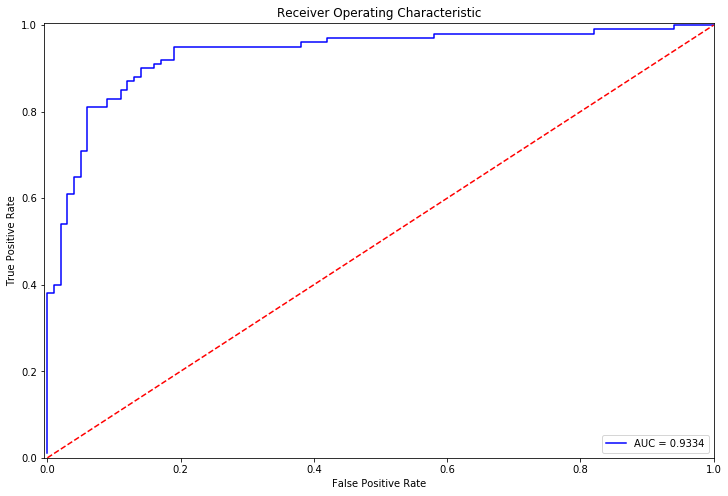

In [30]:
from sklearn.metrics import roc_curve, auc
def plot_roc(y_true, y_score, buffer=0.005):
    fpr, tpr, threshold = roc_curve(y_true, y_score, drop_intermediate=False)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color='b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0-buffer, 1])
    plt.ylim([0, 1+buffer])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

from sklearn.metrics import roc_auc_score, roc_curve
y_score = clf.decision_function(X)
plot_roc(y, y_score)

#### Comparison between prediction, probability, and decision_function(hyperplane distance)

In [60]:
y_pred = clf.predict(X)
y_prob = clf.predict_proba(X)[:,1]

y_df = pd.DataFrame(np.column_stack([y.T, y_pred.T, y_prob.T, y_score.T]), columns=['y','y_pred','y_prob','y_score'])
y_df.sort_values('y_prob').head(10)

,y,y_pred,y_prob,y_score
75,0.0,0.0,0.001913,-5.237664
37,0.0,0.0,0.007787,-4.071627
35,0.0,0.0,0.009354,-3.919183
58,0.0,0.0,0.009438,-3.911738
2,0.0,0.0,0.009929,-3.869617
1,0.0,0.0,0.011961,-3.714751
169,1.0,0.0,0.013501,-3.613981
80,0.0,0.0,0.013628,-3.606163
16,0.0,0.0,0.013982,-3.584852
26,0.0,0.0,0.017182,-3.413251


In [61]:
y_df.sort_values('y_score').head(10)

,y,y_pred,y_prob,y_score
75,0.0,0.0,0.001913,-5.237664
37,0.0,0.0,0.007787,-4.071627
35,0.0,0.0,0.009354,-3.919183
58,0.0,0.0,0.009438,-3.911738
2,0.0,0.0,0.009929,-3.869617
1,0.0,0.0,0.011961,-3.714751
169,1.0,0.0,0.013501,-3.613981
80,0.0,0.0,0.013628,-3.606163
16,0.0,0.0,0.013982,-3.584852
26,0.0,0.0,0.017182,-3.413251


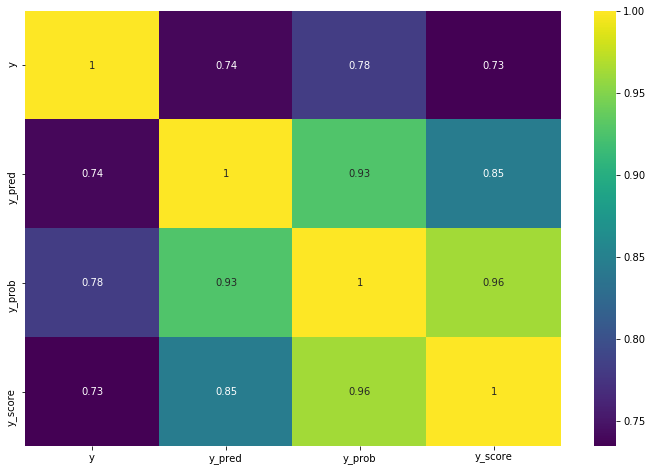

In [68]:
sns.heatmap(y_df.corr(), annot=True, cmap='viridis')

## Parameter Tuning Using GridSearch 

In [158]:
from sklearn.model_selection import GridSearchCV
range_C = list((0.00001,0.0001,0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100))
params = {'C': range_C, 
          'kernel': ['linear','rbf','poly']
          'degree': [2,3,4,5],
          'gamma' : [100,10,1,0.1,0.01,0.001]}

grid_svc = GridSearchCV(svc, params, cv=10, scoring='accuracy', n_jobs=3, verbose=2)
grid_svc.fit(X,y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] C=1e-05, kernel=linear ..........................................
[CV] C=1e-05, kernel=linear ..........................................
[CV] C=1e-05, kernel=linear ..........................................
[CV] ........................... C=1e-05, kernel=linear, total=   0.0s
[CV] ........................... C=1e-05, kernel=linear, total=   0.0s
[CV] C=0.0001, kernel=linear .........................................
[CV] ........................... C=1e-05, kernel=linear, total=   0.0s
[CV] C=1e-05, kernel=linear ..........................................
[CV] C=1e-05, kernel=linear ..........................................
[CV] C=1e-05, kernel=linear ..........................................
[CV] ........................... C=1e-05, kernel=linear, total=   0.0s
[CV] ........................... C=1e-05, kernel=linear, total=   0.0s
[CV] ........................... C=1e-05, kernel=linear, total=   0.0s
[CV] C=1e-05, 

[CV] ............................. C=0.5, kernel=linear, total=   0.0s
[CV] ............................... C=1, kernel=linear, total=   0.0s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=   0.0s
[CV] C=0.5, kernel=linear ............................................
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=   0.0s
[CV] ............................. C=0.5, kernel=linear, total=   0.0s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=   0.0s
[CV] C=0.5, kernel=linear ............................................
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=   0.0s
[CV] ............................. C=0.5, kernel=linear, total=   0.0s
[CV] .

[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.4s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100], 'kernel': ['linear']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

In [121]:
cv_results = pd.DataFrame.from_dict(grid_svc.cv_results_)
cv_results['mean_test_score']
cv_results.columns

Index(['mean_fit_time', 'mean_score_time', 'mean_test_score',
       'mean_train_score', 'param_C', 'param_kernel', 'params',
       'rank_test_score', 'split0_test_score', 'split0_train_score',
       'split1_test_score', 'split1_train_score', 'split2_test_score',
       'split2_train_score', 'split3_test_score', 'split3_train_score',
       'split4_test_score', 'split4_train_score', 'split5_test_score',
       'split5_train_score', 'split6_test_score', 'split6_train_score',
       'split7_test_score', 'split7_train_score', 'split8_test_score',
       'split8_train_score', 'split9_test_score', 'split9_train_score',
       'std_fit_time', 'std_score_time', 'std_test_score', 'std_train_score'],
      dtype='object')

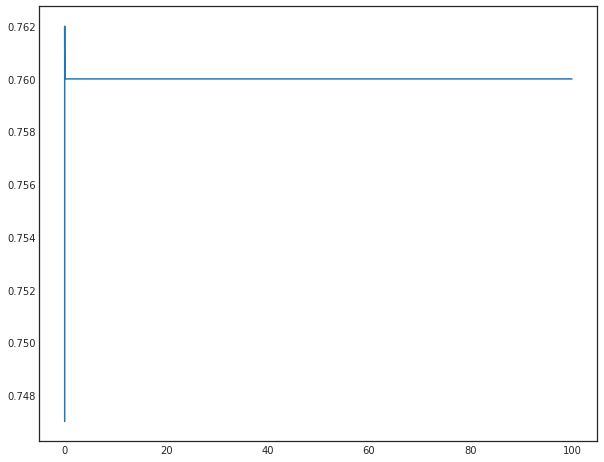

In [159]:
C = [x['C'] for x in cv_results['params']]
mean_test_score = cv_results['mean_test_score']
plt.plot(C,mean_test_score)

In [138]:
grid_svc.best_score_

0.76200000000000001

In [139]:
grid_svc.best_params_

{'C': 0.001, 'kernel': 'linear'}

In [140]:
grid_svc.best_index_

2

# Advanges and Disadvantages
The **advantages** of support vector machines are:
* Effective in high dimensional space
* Not affected by outliers as it uses only a subset of training sets (support vectors)
* Different kernel functions can be used 
    * Linear
    * Poloynomial
    * Radial Basis Function(RBF)
    * Sigmoid
    * Custom

The **disadvantages** of support vector machines are:
* Overfitting when number of features is very large as compared to sample
* Choice of kernel and regularization can have a large impact

---

# ---------------------------------------- Rough Below -------------------------------------------------

# Support Vector Regression (SVR) 
## Using linear and non-linear kernels¶

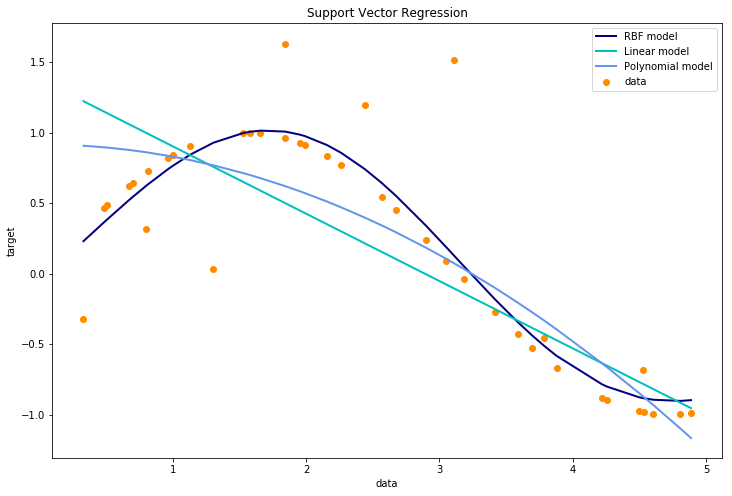

In [2]:
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

# #############################################################################
# Generate sample data
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

# #############################################################################
# Add noise to targets
y[::5] += 3 * (0.5 - np.random.rand(8))

# #############################################################################
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_rbf = svr_rbf.fit(X, y).predict(X)
y_lin = svr_lin.fit(X, y).predict(X)
y_poly = svr_poly.fit(X, y).predict(X)

# #############################################################################
# Look at the results
lw = 2
plt.scatter(X, y, color='darkorange', label='data')
plt.plot(X, y_rbf, color='navy', lw=lw, label='RBF model')
plt.plot(X, y_lin, color='c', lw=lw, label='Linear model')
plt.plot(X, y_poly, color='cornflowerblue', lw=lw, label='Polynomial model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()